# Big Data Project

#**Project Title:** Visualization and Prediction of Heart Disease using Big Data Analytics



In [1]:
# installing the gdown package to download the dataset from the google drive
!pip install gdown

In [2]:
# importing the required libraries
import gdown
import pyspark
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from sklearn.model_selection import RandomizedSearchCV
from pyspark.ml.feature import StringIndexer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, NaiveBayes, DecisionTreeClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier as SklearnRF
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression as SklearnLR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
# extracting the file from the google drive
File_ID = "1B5pTSJc03NEfja3enhS4XKxBsqDpqIPo"
Data = "heart_disease.csv"

# downloading the dataset from the google drive
gdown.download(f"https://drive.google.com/uc?id={File_ID}", Data, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1B5pTSJc03NEfja3enhS4XKxBsqDpqIPo
To: /content/heart_disease.csv
100%|██████████| 38.1k/38.1k [00:00<00:00, 27.3MB/s]


'heart_disease.csv'

In [4]:
# installing java and apache spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.2.1-bin-hadoop2.7.tgz > /dev/null
!pip install -q findspark

In [5]:
# setting up the environment variables for java and apache spark which are installed
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [6]:
# displaying the value of SPARK_HOME and PATH environment variables
!echo $SPARK_HOME
!echo $PATH

/content/spark-3.2.1-bin-hadoop2.7
/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin


In [7]:
# initializing findspark for knowing the location Spark directory
import findspark
findspark.init("/content/spark-3.2.1-bin-hadoop2.7")
print(findspark.find())

/content/spark-3.2.1-bin-hadoop2.7


In [8]:
# displaying the version of java and pyspark which is installed
!java -version
print(pyspark.__version__)

openjdk version "11.0.27" 2025-04-15
OpenJDK Runtime Environment (build 11.0.27+6-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.27+6-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
3.2.1


In [9]:
# initializing the pyspark
!pip install --upgrade pyspark==3.2.1
findspark.init("/content/spark-3.2.1-bin-hadoop2.7")
spark = SparkSession.builder.appName("HeartDiseasePrediction").getOrCreate()
print("Apache Spark is successfully installed and running!")
spark

Apache Spark is successfully installed and running!


In [10]:
# loading the dataset into spark dataframe
dframe_spark = spark.read.csv(Data, header=True, inferSchema=True)

# displaying the dataset schema
dframe_spark.printSchema()

# displaying the first 5 rows of the dataset
dframe_spark.show(5)

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|

In [11]:
# handling the missing values
dframe_spark = dframe_spark.na.drop()
print(f"Number of rows after removing the missing values: {dframe_spark.count()}")

Number of rows after removing the missing values: 1025


In [12]:
# converting the categorical variables based upon the requirement
dta_ind = StringIndexer(inputCol="sex", outputCol="sex_index")
dframe_spark = dta_ind.fit(dframe_spark).transform(dframe_spark)
dframe_spark.show(5)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+---------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|sex_index|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+---------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|      0.0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|      0.0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|      0.0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|      0.0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|      1.0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+---------+
only showing top 5 rows



In [13]:
# feature columns
fea_colmns = [col for col in dframe_spark.columns if col != "target" and col != "sex_index"]

# checking the feature columns to ensure that they are numeric
print("Feature columns:", fea_colmns)

# assembling features into a single column features
from pyspark.ml.feature import VectorAssembler
asmbler = VectorAssembler(inputCols=fea_colmns, outputCol="features")
dframe_spark = asmbler.transform(dframe_spark)

# displaying the first few rows with features and target
dframe_spark.select("features", "target").show(5)


Feature columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
+--------------------+------+
|            features|target|
+--------------------+------+
|[52.0,1.0,0.0,125...|     0|
|[53.0,1.0,0.0,140...|     0|
|[70.0,1.0,0.0,145...|     0|
|[61.0,1.0,0.0,148...|     0|
|[62.0,0.0,0.0,138...|     0|
+--------------------+------+
only showing top 5 rows



In [14]:
# creating a temporary SQL view for querying
dframe_spark.createOrReplaceTempView("heart_disease")

# displaying the count of patients with and without heart disease
dta_qry = "SELECT target, COUNT(*) as count FROM heart_disease GROUP BY target"
res_qry = spark.sql(dta_qry)
res_qry.show()

+------+-----+
|target|count|
+------+-----+
|     1|  526|
|     0|  499|
+------+-----+



In [15]:
# converting the spark dataframe to pandas dataframe for scikit-learn
dframe_pd = dframe_spark.toPandas()

# preparing the feature columns and target column
x = np.array(dframe_pd['features'].apply(lambda x: x.toArray()).tolist())
y = dframe_pd['target']

# splitting the data into training and testing sets
x_tra, x_tes, y_tra, y_tes = train_test_split(x, y, test_size=0.2, random_state=42)

In [16]:
# tuning hyperparameters
smote = SMOTE(random_state=42)
x_tra_resam, y_tra_resam = smote.fit_resample(x_tra, y_tra)

# scaling the features
sc = StandardScaler()
x_tra_sc = sc.fit_transform(x_tra_resam)
x_tst_sc = sc.transform(x_tes)

# adding the polynomial features to capture the non-linearity
poly = PolynomialFeatures(degree=2, interaction_only=True)
x_tra_poly = poly.fit_transform(x_tra_sc)
x_tst_poly = poly.transform(x_tst_sc)

In [17]:
# defining a function to display the performance metrics of the trained model
def evaluate_model_performance(model, x_tst, y_tst):
    y_pred = model.predict(x_tst)
    acc = accuracy_score(y_tst, y_pred)
    rpt = classification_report(y_tst, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall   : {recall_score(y_tst, y_pred):.4f}")
    print(f"F1-score : {f1_score(y_tst, y_pred):.4f}")
    print("Classification Report:\n", rpt)

# Model Training

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

# defining an improved hyperparameter grid
log_param = {
    'C': [1, 10, 100, 500, 1000],
    'penalty': ['l2'],
    'solver': ['saga'],
}

# performing the RandomizedSearchCV
log_mod = RandomizedSearchCV(
    LogisticRegression(max_iter=5000, class_weight='balanced', random_state=16),
    log_param,
    n_iter=1,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# training the model
log_mod.fit(x_tra_poly, y_tra_resam)

# evaluating the model
evaluate_model_performance(log_mod, x_tst_poly, y_tes)

Accuracy: 0.9268
Recall   : 0.9320
F1-score : 0.9275
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       102
           1       0.92      0.93      0.93       103

    accuracy                           0.93       205
   macro avg       0.93      0.93      0.93       205
weighted avg       0.93      0.93      0.93       205



# Naive Bayes

In [19]:
from sklearn.naive_bayes import GaussianNB

# training the model
nb_model = GaussianNB()
nb_model.fit(x_tra_resam, y_tra_resam)

# evaluating the model
evaluate_model_performance(nb_model, x_tes, y_tes)

Accuracy: 0.8000
Recall   : 0.8932
F1-score : 0.8178
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.71      0.78       102
           1       0.75      0.89      0.82       103

    accuracy                           0.80       205
   macro avg       0.81      0.80      0.80       205
weighted avg       0.81      0.80      0.80       205



# Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier

# defining hyperparameters
dt_param = {'max_depth': [5,10, None], 'min_samples_split': [2,5]}

# performing RandomizedSearchCV
dt_mod = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), dt_param, n_iter=5, cv=3, n_jobs=-1)
dt_mod.fit(x_tra_resam, y_tra_resam)

# evaluating the model
evaluate_model_performance(dt_mod, x_tes, y_tes)


Accuracy: 0.9854
Recall   : 0.9709
F1-score : 0.9852
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



# SVM Classifier

In [21]:
from sklearn.svm import SVC

# defining hyperparameters
svm_param = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']}

# performing RandomizedSearchCV
svm_mod = RandomizedSearchCV(SVC(kernel='rbf', probability=True, random_state=42), svm_param, n_iter=5, cv=3, n_jobs=-1)
svm_mod.fit(x_tra_resam, y_tra_resam)

# evaluating the model
evaluate_model_performance(svm_mod, x_tes, y_tes)


Accuracy: 0.9610
Recall   : 0.9223
F1-score : 0.9596
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       102
           1       1.00      0.92      0.96       103

    accuracy                           0.96       205
   macro avg       0.96      0.96      0.96       205
weighted avg       0.96      0.96      0.96       205



# Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

# defining hyperparameters
rf_param = {
    'n_estimators': [150, 200, 250],
    'max_depth': [12, 15, 18],
    'min_samples_split': [4, 6, 8],
    'min_samples_leaf': [3, 4, 5],
    'max_features': ['sqrt', 'log2']
}

# performing RandomizedSearchCV
rf_mod = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_param, n_iter=5, cv=3, n_jobs=-1)
rf_mod.fit(x_tra_resam, y_tra_resam)

# evaluating the model
evaluate_model_performance(rf_mod, x_tes, y_tes)


Accuracy: 0.9463
Recall   : 0.9417
F1-score : 0.9463
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95       102
           1       0.95      0.94      0.95       103

    accuracy                           0.95       205
   macro avg       0.95      0.95      0.95       205
weighted avg       0.95      0.95      0.95       205



# KNN Classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier

# defining hyperparameters
knn_param = {'n_neighbors': [3, 5, 7, 9, 11], 'metric': ['euclidean']}

# performing RandomizedSearchCV
knn_mod = RandomizedSearchCV(KNeighborsClassifier(), knn_param, n_iter=5, cv=3, scoring='accuracy', n_jobs=-1)
knn_mod.fit(x_tra_resam, y_tra_resam)

# evaluating the model
evaluate_model_performance(knn_mod, x_tes, y_tes)

Accuracy: 0.9171
Recall   : 0.9126
F1-score : 0.9171
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       102
           1       0.92      0.91      0.92       103

    accuracy                           0.92       205
   macro avg       0.92      0.92      0.92       205
weighted avg       0.92      0.92      0.92       205



# XG Boost

In [24]:
import xgboost as xgb

# defining hyperparameters
xgb_param = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01], 'max_depth': [6, 10]}

# performing RandomizedSearchCV
xgb_mod = RandomizedSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                               xgb_param, n_iter=5, cv=3, n_jobs=-1)
xgb_mod.fit(x_tra_resam, y_tra_resam)

# evaluating the model
evaluate_model_performance(xgb_mod, x_tes, y_tes)

Accuracy: 0.9854
Recall   : 0.9709
F1-score : 0.9852
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



# Stacking CV Classifier

In [25]:
from sklearn.ensemble import StackingClassifier

# defining the base estimators using best models found.
estimators = [
    ('KNN', knn_mod.best_estimator_),
    ('Random Forest', rf_mod),
    ('Logistic Regression', log_mod.best_estimator_),
    ('Decision Tree', dt_mod.best_estimator_),
    ('SVM', svm_mod.best_estimator_),
    ('XGBoost', xgb_mod.best_estimator_)
]

# defining and training the model
stack_cv_mod = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=3)
stack_cv_mod.fit(x_tra_resam, y_tra_resam)

# evaluating the model
evaluate_model_performance(stack_cv_mod, x_tes, y_tes)

Accuracy: 0.9854
Recall   : 0.9709
F1-score : 0.9852
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



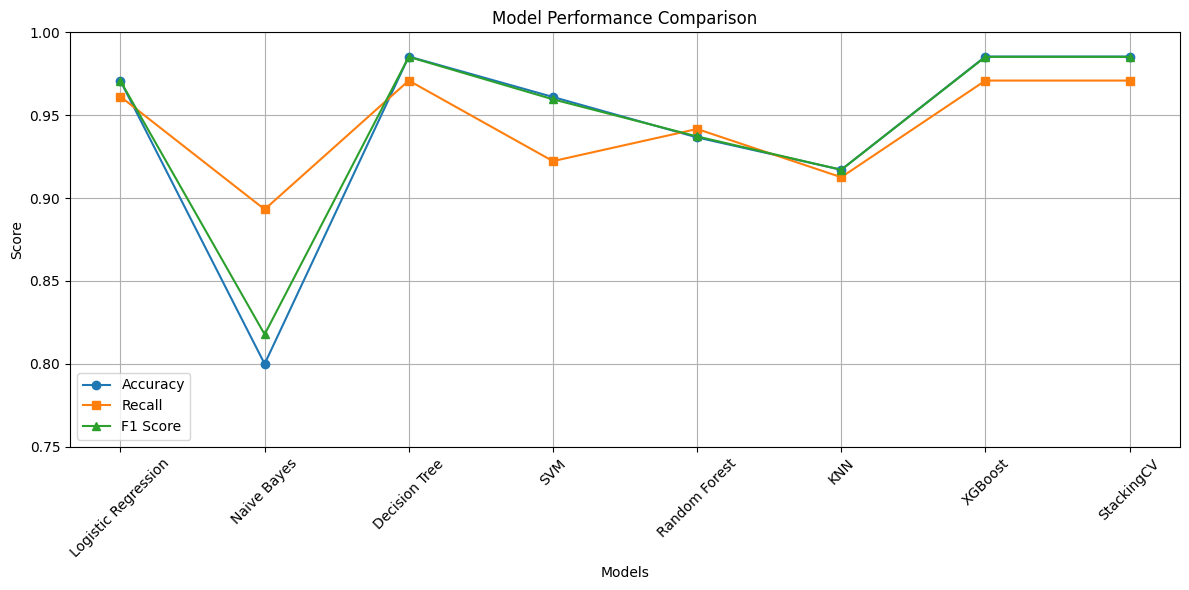

In [26]:
# visulaizing the evaluating metrics of the trained models
import matplotlib.pyplot as plt
modl = [
    'Logistic Regression', 'Naive Bayes', 'Decision Tree', 'SVM',
    'Random Forest', 'KNN', 'XGBoost', 'StackingCV'
]
acc = [0.9707, 0.8000, 0.9854, 0.9610, 0.9366, 0.9171, 0.9854, 0.9854]
rec = [0.9612, 0.8932, 0.9709, 0.9223, 0.9417, 0.9126, 0.9709, 0.9709]
f1 = [0.9706, 0.8178, 0.9852, 0.9596, 0.9372, 0.9171, 0.9852, 0.9852]

# plotting the metrics
plt.figure(figsize=(12, 6))
x = range(len(modl))
plt.plot(x, acc, marker='o', label='Accuracy')
plt.plot(x, rec, marker='s', label='Recall')
plt.plot(x, f1, marker='^', label='F1 Score')
plt.xticks(x, modl, rotation=45)
plt.ylim(0.75, 1.0)
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()